# Simulación para los smart contracts


In [ ]:
!pip install plotly

In [ ]:
# Importación de librerias 

# Númericas
import numpy as np         # Para trabajar arreglos matriciales
import random              # Para determinar valores aleatorios
import scipy.stats as ss   # Aleatoriedad atada a una distribución de probabilidad
import pandas as pd
import math 

# Gráficas
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import plotly.graph_objects as go

![texto del enlace](Conceptos importantes/Parámetros para la definición de un mercado.png)

In [ ]:
# Numero de bloques por año en la red

ETHBlocks = 4*60*24*365
RSKBlocks = ETHBlocks/2

# Collateral Factors - Uno por cada mercado

collFactor_MK1 = 0.75  # Collateral factor para el mercado MK1
collFactor_MK2 = 0.75  # Collateral factor para el mercado MK2

# Lista con los Collateral Factors
collateralFactors = [collFactor_MK1,collFactor_MK2]

# Reserve Factors - Uno por cada mercado

reserveFactor_MK1 = 0.20   # Reserve Factor para el mercado MK1
reserveFactor_MK2 = 0.15   # Reserve Factor para el mercado MK2
 
# Lista con los Reserve Factors                    
reserveFactors = [reserveFactor_MK1,reserveFactor_MK2]

# Mínimo suministrado permitido

minAmount = 1*10**(-18)

# Máximo permitido por mercado

maxAmountMK1 = 1  # 1 BTC
maxAmountMK2 = 10000  # 10000 USDC
maxAmount = [maxAmountMK1,maxAmountMK2]

# Precios iniciales por mercado

priceMK1 = 50000  # BTC price in USD
priceMK2 = 1.01  # USDC price in USD
initialMarketPrices = [priceMK1,priceMK2]

In [ ]:
def repairDecimals(number):
  """Se deja en terminos de 13 decimales"""
  return int(number*1e13)/1e13

# El modelo de tasas de interés - Una expresión para todos los mercados

def getBorrowAPR_volatileMarket(utilizationRate,baseBorrowRate=0.02,slope=0.1):  
    """Interest model for volatile markets"""
    return repairDecimals(baseBorrowRate + slope*utilizationRate)

def getBorrowAPR_stableMartet(utilizationRate,baseBorrowRate=0.02,slope1=0.05,slope2=1,optimalUtilization=0.8):   
    """Interest model for "stable" markets"""
    if utilizationRate <= optimalUtilization: 
        return repairDecimals(baseBorrowRate + slope1*utilizationRate)
    else:
        return repairDecimals((baseBorrowRate + (slope1 - slope2)*optimalUtilization) + slope2*utilizationRate)

def getSupplyAPR(borrowRate,reserveFactor,utilizationRate): 
    return repairDecimals(borrowRate*utilizationRate*(1 - reserveFactor))

def ratePerBlock(rateAPR,blockPerYear=ETHBlocks):
    return repairDecimals(rateAPR/blockPerYear)

def preutilization_volatileMarket(borrowRate,baseBorrowRate=0.02,slope=0.1):
    """inverse of the interest rate model for volatile markets"""
    return repairDecimals((borrowRate - baseBorrowRate)/slope)

def preutilization_stableMarket(borrowRate,baseBorrowRate=0.02,slope1=0.05,slope2=1,optimalUtilization=0.8):
    """inverse of the interest rate model for volatile markets"""
    if borrowRate <= getBorrowAPR_stableMartet(optimalUtilization):
        return preutilization_volatileMarket(borrowRate,baseBorrowRate,slope1)
    else:
        return repairDecimals((borrowRate - (baseBorrowRate + (slope1 - slope2)*optimalUtilization))/slope2)

In [ ]:
# Formato de visualización del mercado

def fixLen(value, isNumber=False):
    if isNumber: 
        value = '%.5f' % value
        value = value[:9]
    return '{:9s}'.format(str(value))

def printMarket(market):
    """Market display format"""
    blockNumber = 0
    for marketAtblock in market:
        #print('InterestIndexArray:', marketAtblock[9])
        print('accrualBlockNumber:', marketAtblock[5], '\t exchangeRate:', marketAtblock[4],
              '\t marketPrice:', marketAtblock[2])
        totalBorrows = marketAtblock[6]+marketAtblock[11]
        print('totalSupplies:', marketAtblock[7], '\t totalBorrows:', totalBorrows,
              '\t totalReserves:', marketAtblock[3])
        print('borrowRateAPR:', marketAtblock[0], '\t supplyRateAPR:', marketAtblock[1],
              '\t MarketCash:', marketAtblock[8])
        print('MarketIndex:', marketAtblock[9][-1],'\t Margen:', marketAtblock[10], '\n')
        print('|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|')
        print('| ',fixLen('# Block'),' | ',fixLen('UserIdx'),' | ',fixLen('Action'),' | ',
              fixLen('Amount'),' | ',fixLen('Supply'),' | ',fixLen('SPlusI'),' | ',
              fixLen('Borrow'),' | ',fixLen('IUIdx'),' |')    
        print('|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|')
        userIndex = 0
        for user in marketAtblock[12:]:
            print('| ',fixLen(blockNumber),' | ',fixLen(userIndex),' | ',fixLen(user[0]),' | ',fixLen(user[1], True),
                  ' | ',fixLen(user[2], True),' | ',fixLen(user[3], True),' | ',fixLen(user[4], True),' | ',fixLen(user[5]),' |')
            userIndex += 1
        blockNumber+=1
        print('|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|','-'*11,'|')

## Estructura de los mercados

Dado que el estado de cada mercado se actualiza en cada bloque, debemos implementar una manera adecuada de conocer el estado del mercado y además, el estado de cada usuario (balance de la cuenta y movimientos de cada usuario). 

![texto del enlace](Imagenes/market_structure.jpg)

Cada mercado en cada bloque tiene un estado similar a la imágen anterior, cada casilla cumple una función especifica:
1.   **Borrow rate:** Es la tasa de prestamo actual, esta se calcula en base a la tasa de utilización del bloque anterior.
2.   **Supply rate:** Es la tasa de suministro actual, o de otra forma, será la tasa a la cual el lender esta ganando intereses en función de su capital suministrado. Al igual que el *borrow rate*, se calcula en base al bloque anterior.
3.   **Token price:** Es el precio actual del mercado, es una variable independiente del protocolo y viene dada por un oraculo.
4.  **Total pool reserves:** Es la cantidad de reservas actuales en el mercado.
5.  **Exchange rate:** Tasa de cambio entre tokens y ctokens en el bloque actual.
6.  **t:** Es la cantidad de bloques que lleva la tasa *borrow rate*, tambien se puede entender como la cantidad de bloques en las que no se ha hecho ninguna acción por parte de los usuarios.
7.  **Total borrow:** Es la cantidad total de tokens prestados (junto con intereses) en el mercado en el bloque actual.
8.  **Total supply:** Es la cantidad total de tokens suministrados en el mercado.
9.  **Movimiento de usuarios y registro de acciones:** En esta casilla se guardan las carteras y las acciones que realizará cada usuario en el bloque actual, cada elemento en esta casilla se puede ver como: 
![texto del enlace](Imagenes/user_structure.jpg)

Todos los usuarios que hagan parte del mercado poseen las caracteristicas o datos que se ven en el diagrama anterior: 
*   En la primera casilla encontramos la *acción* que realiza el usuario, en cada bloque cada usuario puede realizar una de cinco acciones: *supply* (o suministrar liquidez), *borrow*, *withdraw*, *repay* o no hacer nada.
*   En la segunda casilla encontramos el amount, será el monto o la cantidad de tokens que se emplean dependiendo de la acción.
*   En la tercera y cuarta posición encontramos los datos correspondientes al supply del usuario, en la tercera los montos que suministra el usuario y en la cuarta lo suministrado mas los intereses que se van acumulando.
*   Finalmente en las quinta y sexta posición encontramos los datos correspondientes a los prestamos que realice el usuario en el mercado. De manera análoga se guardan en la quinta posición los montos que se solicitan como prestamo y en la sexta posición los montos prestados mas los intereses que se generan por la deuda.


## Configuración de un mercado

Para crear el entorno inicial debemos tener presente varios factores que influiran de manera significativa en nuestra simulación.

Lo primero es establecer la cantidad de usuarios que vamos a considerar, está debe ser la misma para todos los mercados que se quieran crear. Una vez establecido este valor debemos "llamar" los valores ya establecidos por gobernanza y podremos crear tantos mercados como necesitemos.

In [ ]:
def marketSetUp(n_users,reserveFactor,initialSuppliersRate,initialTokenPrice,maxAmountSupply,interestModel):
    """
    Initial configuration of a market
    
    n_users :              Number of users to be taken into account
    reserveFactor :        reserve factor for the market
    initialSuppliersRate : Percentage of the users that make an supply at initial state of the market
    initialTokenPrice :    Initial price of the market token in USD
    maxAmountSupply :      Maximum amount allowed for a supply
    interestModel :        Interest model considered for the borrow rate of the market
    """
    market = []  
    borrowRate = interestModel(0)
    supplyRate = getSupplyAPR(borrowRate,reserveFactor,0)
    initialExchangeRate = 50
    market.append(borrowRate)   # Borrow rate with utilizationRate = 0, 0
    market.append(supplyRate)   # Supply rate with utilizationRate = 0, 1
    market.append(initialTokenPrice)  # Initial Price Market, 2
    market.append(0)  # Total Reserve, 3
    market.append(initialExchangeRate) # Exchange Rate, 1 token == 50 ctokens, 4
    market.append(0)  # Accrual block number, 5
    market.append(0)  # TotalBorrow in Market, 6
    market.append(0)  # TotalSupplied in Market, 7
    market.append(0)  # Market cash, 8
    market.append([ratePerBlock(borrowRate)])  # Interest index, 9
    market.append(0)  # Margen, 10
    market.append(0)  # Accrue interest, 11
    for i in range(n_users):
        r = random.random()
        if r <= initialSuppliersRate:
            supplied = random.uniform(minAmount,maxAmountSupply)
            userSupply = ("s",supplied,supplied,supplied*initialExchangeRate,0,0)
            market.append(userSupply)
        else:
            market.append(("x",0,0,0,0,0))
    supply = 0
    for user in market[12:]:
        supply += user[2]
    reserve = supply*reserveFactor
#     market[3] = reserve  # Market reserve
    market[7] = supply   # Market total supply
    market[8] = supply #- reserve # Market Cash
    return [market]

## Actualización de dinámicas del mercado

Dado que en cada bloque debemos conocer el estado del mercado, debemos establecer mecanismos para actualizar todas las posibles variables de cada mercado.

La manera en la que se actualizarán las tasas de interés vendrá dada por el modelo de interés y el comportamiento del mercado en el bloque anterior, esto quiere decir que en el bloque $n$ las tasas $\text{Borrow rate}$ y $\text{Supply rate}$ dependerán de la tasa de utilización (relación entre oferta y demanda) del bloque $n-1$.

Recordemos que la tasa de utilización esta dada por la siguiente ecuación:

$$\text{Utilization rate}=\frac{Total Borrow}{Total supply}\approx\frac{Total Borrow}{Total Supply+TotalBorrow}$$

De ese modo, construiremos las funciones que nos permitiran determinar los posibles cambios en las diferentes tasas del mercado en el último bloque generado:

# Stable coins
$$\text{Utilization rate}=\frac{Total Borrow}{Total Liquility + Total Borrow}$$

Borrow rate:

$$\text{Borrow rate}=\left\{\begin{array}{ll}
\text{baseBorrowRate}+\text{slope}_{1}*\text{UtilizationRate} & \text{si } utilizationRate\leq kink\\
\text{crossPoint}+\text{solpe}_{2}*\text{UtilizationRate} & \text{otherwise}\end{array}\right.$$

Supply rate:

$$\text{Supply rate}={utilization Rate*borrowRate}*({1-reserveFator})$$

In [ ]:
# Calculo de la tasa de utilización del mercado en el bloque actual

def getUtilizationRate(market,blockNumber,reserveFactor):  # Recibe el nuevo bloque
    """
    Market utilization rate in the specific block
    
    blockNumber : Receive the new block
    """
    if blockNumber == 1 or blockNumber == 0:
        return 0
    # Utilización con la que empieza el nuevo bloque
    totalSupply = repairDecimals(totalSupplyMarket(market,blockNumber))
    cashAtBlock = repairDecimals(market[blockNumber-1][8])
    totalBorrowTokens = 0
    for user in market[blockNumber-1][12:]:
        # Tokens que se prestaron en el bloque anterior
        if user[0] == "b":
            totalBorrowTokens += user[1]
        elif user[0] == "s":
            cashAtBlock += user[1]
    totalBorrowTokens = repairDecimals(totalBorrowTokens)
    totalBorrowTokens += totalSupply - cashAtBlock
    utilizationRate = repairDecimals(totalBorrowTokens/totalSupply)
    return utilizationRate  # Retorna un valor porcentual

# Calculo de la tasa Borrow rate (por el momento se esta tomando la tasa APR)

def borrowRateAPR(market,blockNumber,interestModel,reserveFactor): # Recibe el nuevo bloque
    """
    Calculates the borrow rate APR let by the market utilization rate
    
    blockNumber : Receive the new block
    """
    utilizationRate = getUtilizationRate(market, blockNumber, reserveFactor)
    borrowAPR = repairDecimals(interestModel(utilizationRate))
    return borrowAPR  # Retorna un valor porcentual

# Calculo de la tasa Supply rate (por el momento se esta tomando la tasa APR)

def supplyRateAPR(market,blockNumber,reserveFactor,borrowRatePerBlock):  # Recibe el nuevo bloque
    """
    Calculates the supply rate APR let by the market utilization rate
    
    blockNumber : Receive the new block
    """
    utilizationRate = getUtilizationRate(market, blockNumber, reserveFactor)
    supplyAPR = repairDecimals(getSupplyAPR(borrowRatePerBlock, reserveFactor, utilizationRate))
    return supplyAPR  # Retorna un valor porcentual

# Total balance supplied in the market in tokens

def totalSupplyMarket(market,blockNumber):  # Se recibe el nuevo blockNumber
    """
    Total balance supplied in the market in tokens
    
    blockNumber : Receive the new block
    """
    supply = 0
    for user in market[blockNumber-1][12:]:
        supply += user[2]   # Se toman unicamente las cantidades suministradas sin intereses
    return repairDecimals(supply)

In [ ]:
def hasChangeBorrowRate(market,blockNumber,newBorrowRate):  # Se recibe el nuevo blockNumber 
    """
    Check if the borrow rate changes to update the delta and interestIndex for the block blockNumber
    
    blockNumber : Receive the new block 
    """
    return market[blockNumber-1][0] != newBorrowRate  # Si es True, la tasa cambio

# Funcion para calcular los delta, i.e. espacio entre acciones en numero de bloques

def accrualBlockNumber(market, blockNumber, newBorrowRate):  # Se recibe el nuevo blockNumber
    """
    Reports the delta value and the last index (rate per block) calculated.
    
    blockNumber : Receive the new block 
    """
    # 
    if blockNumber == 0:
        return (0,[ratePerBlock(newBorrowRate)])
    borrowRateChanged = hasChangeBorrowRate(market,blockNumber,newBorrowRate)  # New Borrow Rate
    if borrowRateChanged == False:  # No cambio el borrow rate
        indexes = market[blockNumber-1][9]
        delta = market[blockNumber-1][5]+1
        return (delta, indexes)
    else:  # Si la tasa cambio
        indexesCopy = []
        for index in market[blockNumber-1][9]:
            indexesCopy.append(index)
        delta = market[blockNumber-1][5]+1
        lastI = market[blockNumber-1][9][-1]
        borrowRate = market[blockNumber-1][0]
        indexPerBlock = lastI*(1+delta*ratePerBlock(borrowRate))
        indexes = market[blockNumber-1][9]
        temporalIndexes = []
        for i in indexes:
            temporalIndexes.append(i)
        temporalIndexes.append(indexPerBlock)
        return (0,temporalIndexes)

In [ ]:
# Intereses generados por las deudas activas

def accrueInterest(market,blockNumber,newBorrowRate):
    """
    Calculates the accrue interest if borrowRate has changes
    
    blockNumber : Receive the new block
    newBorrowRate : Borrow rate at which the new block starts
    """
    if blockNumber == 0 or blockNumber == 1:
        return 0
    delta, indexes = accrualBlockNumber(market,blockNumber,newBorrowRate)
    if delta == 0:
        return 0
    else:
        return repairDecimals(market[blockNumber-1][6]*ratePerBlock(market[blockNumber-1][0])*delta)

# Saldo total prestado + intereses del mercado en tokens

def totalBorrowMarket(market,blockNumber,newBorrowRate):  # Se recibe el nuevo blockNumber
    """
    Total balance borrowed + market interest in tokens
    
    blockNumber :   Receive the new block
    newBorrowRate : Borrow rate at which the new block starts
    """
    if blockNumber == 0 or blockNumber == 1:
        return 0
    totalTokensBorrow = market[blockNumber-1][6]
    delta, indexes = accrualBlockNumber(market,blockNumber,newBorrowRate)
    if delta != 0:
        return totalTokensBorrow
    else:
        totalBorrow = 0  
        totalRepay = 0
        for user in market[blockNumber-1][12:]:
            if user[0] == "b":
                totalBorrow += user[1]
            elif user[0] == "r":
                totalRepay += user[1]
        # print((totalTokensBorrow)*(indexes[-1]/indexes[-2]))
        return repairDecimals((totalTokensBorrow)*(indexes[-1]/indexes[-2]) + totalBorrow - totalRepay)

In [ ]:
I0 = ratePerBlock(0.02)
I1 = I0*(1+2*I0)
I2 = I1*(1+ratePerBlock(0.0222727272727)) 

repairDecimals(2.003e-10*0.2)
# print(repairDecimals(repairDecimals((0.0200000002118/0.02-1)*0.2*.02)+repairDecimals(2.003e-10*0.2)))

4e-11

In [ ]:
# Se actualizan las reservas de acuerdo con las acciones de los usuarios en el bloque anterior

def totalPreviousReserves(market,blockNumber):  # Se recibe el nuevo blockNumber
    """
    Reserves are updated according to user actions in the previous block
    
    blockNumber : Receive the new block
    """
    if blockNumber == 0 or blockNumber == 1:
        return 0
    withdraws = 0
    repays = 0
    for user in market[blockNumber-1][12:]:
        if user[0] == "w":
            withdraws += user[1]
        if user[0] == "r":
            repays += user[1]
    balanceMarket = market[blockNumber-1][8] - withdraws + repays  # Lo que habia - lo que se saco + las deudas que se pagaron
    if balanceMarket <= 0:
        newTotalReserve = market[blockNumber-1][3] + balanceMarket
    else:
        newTotalReserve = market[blockNumber-1][3]
    return newTotalReserve

def totalReserveMarket(market,blockNumber,reserveFactor,newBorrowRate):  # Se recibe el nuevo blockNumber
    """
    Calculate the amount of reserves plus interest with which the new block starts
    
    blockNumber :   Receive the new block
    newBorrowRate : Borrow rate at which the new block starts
    """
    if blockNumber == 0 or blockNumber == 1:
        return market[0][3]
    previousTotalReserve = totalPreviousReserves(market,blockNumber)
    delta, indexes = accrualBlockNumber(market,blockNumber,newBorrowRate)
    if delta == 0:
        if len(indexes) >= 2:
            previousTotalReserve += market[blockNumber-1][6]*(indexes[-1]/indexes[-2]-1)*reserveFactor
            return repairDecimals(previousTotalReserve)
        else:
            return 0
    else:
        return repairDecimals(previousTotalReserve)

In [ ]:
# Liquidez total del mercado 

def getMarketCash(market,blockNumber,reserveFactor,newBorrowRate): # Recibe el nuevo bloque
    """
    Liquidity with which the new block starts
    
    blockNumber :   Receive the new block
    newBorrowRate : Borrow rate at which the new block starts
    """
    if blockNumber == 1:
        return market[0][8]
    totalCash = market[blockNumber-1][8]
    for user in market[blockNumber-1][12:]:
        if user[0] == "s" or user[0] == "r":
            totalCash += user[1]
        elif user[0] == "b":
            totalCash -= user[1]
        elif user[0] == "w":
            totalCash = max(0,totalCash - user[1])
    return repairDecimals(totalCash)

In [ ]:
def getMargenMarket(market,blockNumber,reserveFactor,newBorrowRate,interestModel):
    """
    Calculates the profit margin of the protocol in each block
    
    blockNumber: Receive the new block
    """
    if blockNumber == 0 or blockNumber == 1:
          return 0
    previousMargen = market[blockNumber-1][10]
    delta, indexes = accrualBlockNumber(market,blockNumber,newBorrowRate)
    if delta == 0:
          if len(indexes) >= 2:
              utilizationRate = getUtilizationRate(market,blockNumber,reserveFactor)
              previousMargen += repairDecimals(market[blockNumber-1][6]*(indexes[-1]/indexes[-2]-1))*(1-reserveFactor-utilizationRate)
              return repairDecimals(previousMargen)
          else:
              return 0
    else:
          return repairDecimals(previousMargen)

In [ ]:
# Tasa de cambio para un mercado

def exchangeRateMarket(market,blockNumber,reserveFactor,marketCash,totalBorrow,totalReserves,newBorrowRate):
    """
    Exchange rate between market tokens and ctokens
    
    blockNumber :   Receive the new block
    marketCash :    Total cash at the last market block
    totalBorrow :   Total borrowed at the last market block
    totalReserves : Total reserves at the last market block
    """
    if blockNumber == 0:
        return 50   # exchangeRate inicial
    else:
        totalSupply = totalSupplyMarket(market,blockNumber)
        cTokenMinted = totalSupply*market[blockNumber-1][4]
        delta, indexes = accrualBlockNumber(market,blockNumber,newBorrowRate)
        AccrueInterest = accrueInterest(market,blockNumber,newBorrowRate)
        if delta == 0:
            if marketCash + totalBorrow + AccrueInterest!= 0:
                exchangeRate = cTokenMinted/(marketCash + totalBorrow + AccrueInterest)
            return repairDecimals(exchangeRate)
        else:
            return repairDecimals(market[blockNumber-1][4])

In [ ]:
repairDecimals(0.00000000022472591710140791476)

2.247e-10

In [ ]:
# Estado inicial de los mercados
# boR,suR,price,reserve,exR,delta,TB,TS,C,index,M

block0 = [0.02,0,50000,0,50,0,0,0.88,0.88,[9.5129e-09],0,0,
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('s', 0.8, 0.8, 40, 0, 0),
  ('s', 0.08, 0.08, 4, 0, 0)]

block1 = [0.02,0,50000,0,50,1,0,0.88,0.88,[9.5129e-09],0,0,
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('s', 0.5, 0.5, 2.5, 0, 0),
  ('x', 0, 0.8, 40, 0, 0),
  ('b', 0.05, 0.08, 4, 0.05, 0)]

block2 = [0.0236231884057,0.0006847300987,50000,0,50,0,0.05,1.38,1.33,[9.5129e-09,9.512900180990533e-09],0,0,
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0.5, 2.5, 0, 0),
  ('x', 0, 0.8, 40, 0, 0),
  ('x', 0, 0.05, 4, 0.05, 0)]

block3 = [0.0210638297872,0.0001792666364,50000,0,50,0,0.05,1.38,1.33,[9.5129e-09,9.512900180990533e-09],2.247e-10,0,
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 1, 50, 0, 0),
  ('x', 0, 0.8, 40, 0, 0),
  ('x', 0, 0.08, 4, 0.02, 0)]

block4 = [0.0210638297872,0.0001792666364,50000,8.22e-11,49.99999999436702,1,0.0200000002118,1.88,1.86,
      [9.5129e-09,9.512900180990533e-09,9.512900281769246e-09],1.646e-10,2.003e-10,
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 0, 0, 0, 0),
  ('x', 0, 1, 50, 0, 0),
  ('x', 0, 0.8, 40, 0, 0),
  ('x', 0, 0.08, 4, 0.02, 0)]

M1 = [block0, block1, block2, block3, block4]

# Margen --> 0.00000000022-0.00000000022*0.2-0.00000000022*0.02272727273
# Nuevo interes --> 0.02000000022*9.512937690438974e-09/9.512937595129376e-09
# Reservas --> (0.020000000420378902-0.02000000022)*0.2 + 4.4e-11
# ExchangeRate --> (1.88*49.99999999531914)/(1.86 + 0.020000000420378902 - 8.407578019438186e-11)

# La utilización bien;BorrowRate bien;SupplyRate bien;AccrualBlockNumber bien;indices bien;TotalBorrow bien:AccrueInterest bien;reservas bien; cash bien
# margen talvez

# Bloque2
print(2)
ut1 = getUtilizationRate(M1,2,0.02)
Br1 = getBorrowAPR_volatileMarket(ut1)
Sr1 = getSupplyAPR(Br1,0.2,ut1)
delta = accrualBlockNumber(M1,2,Br1)[0]
TB = totalBorrowMarket(M1,2,Br1)
acI = accrueInterest(M1,2,Br1)
TR = totalReserveMarket(M1,2,0.2,Br1)
C = getMarketCash(M1,2,0.2,Br1)
M = getMargenMarket(M1,2,0.2,Br1,getBorrowAPR_volatileMarket)
Er = exchangeRateMarket(M1,2,0.2,C,TB,TR,Br1)
Erc = M1[2][4]
print(Er,Erc,Er == Erc)

# Bloque3
print(3)
ut1 = getUtilizationRate(M1,3,0.02)
Br1 = getBorrowAPR_volatileMarket(ut1)
Sr1 = getSupplyAPR(Br1,0.2,ut1)
delta = accrualBlockNumber(M1,3,Br1)[0]
TB = totalBorrowMarket(M1,3,Br1)
acI = accrueInterest(M1,3,Br1)
TR = totalReserveMarket(M1,3,0.2,Br1)
C = getMarketCash(M1,3,0.2,Br1)
M = getMargenMarket(M1,3,0.2,Br1,getBorrowAPR_volatileMarket)
Er = exchangeRateMarket(M1,3,0.2,C,TB,TR,Br1)
Erc = M1[3][4]
print(Er,Erc,Er == Erc)

# Bloque4
print(4)
ut1 = getUtilizationRate(M1,4,0.02)
Br1 = getBorrowAPR_volatileMarket(ut1)
Sr1 = getSupplyAPR(Br1,0.2,ut1)
delta = accrualBlockNumber(M1,4,Br1)[0]
TB = totalBorrowMarket(M1,4,Br1)
acI = accrueInterest(M1,4,Br1)
TR = totalReserveMarket(M1,4,0.2,Br1)
C = getMarketCash(M1,4,0.2,Br1)
M = getMargenMarket(M1,4,0.2,Br1,getBorrowAPR_volatileMarket)
Er = exchangeRateMarket(M1,4,0.2,C,TB,TR,Br1)
Erc = M1[4][4]
print(Er,Erc,Er == Erc)

2
50.0 50 True
3
49.999999994367 49.99999999436702 False
4
49.999999994367 49.99999999436702 False


In [ ]:
def setMarketVariablesInBlock(market, blockNumber, reserveFactor, marketPrice, interestModel): # Recibe el nuevo bloque
    """
    Updates market variables based on stock and market status in the previous block
    
    blockNumber : Receive the new block
    marketPrice : The new market price
    """
    # Condiciones de mercado
    # --------------------------------------------------------------------------------------------------------------------
    borrowRate = borrowRateAPR(market,blockNumber,interestModel,reserveFactor)
    supplyRate = supplyRateAPR(market,blockNumber,reserveFactor,borrowRate)
    delta, indexes = accrualBlockNumber(market,blockNumber,borrowRate)
    totalSupply = totalSupplyMarket(market,blockNumber)
    totalBorrow = totalBorrowMarket(market,blockNumber,borrowRate)
    totalReserve = totalReserveMarket(market,blockNumber,reserveFactor,borrowRate)
    marketCash = getMarketCash(market,blockNumber,reserveFactor,borrowRate)
    exchangeRate = exchangeRateMarket(market,blockNumber,reserveFactor,marketCash,totalBorrow,totalReserve,borrowRate)
    margen = getMargenMarket(market,blockNumber,reserveFactor,borrowRate,interestModel)
    # --------------------------------------------------------------------------------------------------------------------
    mkAtBlock = [('x', 0, 0, 0, 0, 0)] * len(market[0])
    mkAtBlock[0] = borrowRate
    mkAtBlock[1] = supplyRate
    mkAtBlock[5] = delta 
    mkAtBlock[9] = indexes
    mkAtBlock[7] = totalSupply
    mkAtBlock[6] = totalBorrow
    mkAtBlock[3] = totalReserve
    mkAtBlock[8] = marketCash
    mkAtBlock[4] = exchangeRate
    mkAtBlock[2] = marketPrice
    mkAtBlock[10] = margen
    # --------------------------------------------------------------------------------------------------------------------
    userIndex = 11
    for users in market[blockNumber-1][11:]: 
        mkAtBlock[userIndex] = market[blockNumber-1][userIndex] 
        userIndex += 1 
    return mkAtBlock

printMarket([setMarketVariablesInBlock(M1,5,0.2,50000,getBorrowAPR_volatileMarket)])

accrualBlockNumber: 2 	 exchangeRate: 49.99999999436702 	 marketPrice: 50000
totalSupplies: 1.88 	 totalBorrows: 0.0200000004121 	 totalReserves: 8.22e-11
borrowRateAPR: 0.0210638297872 	 supplyRateAPR: 0.0001792666364 	 MarketCash: 1.86
MarketIndex: 9.512900281769246e-09 	 Margen: 1.646e-10 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  x          |  0.00000    |  1.00000    |  50.00000   |  0.00000    |  0          |
|  0          |  3   

In [ ]:
ETHBlocks = 4*60*24*365
collFactor_MK1 = 0.5; collFactor_MK2 = 0.75; collateralFactors = [collFactor_MK1,collFactor_MK2]
reserveFactor_MK1 = 0.20; reserveFactor_MK2 = 0.15; reserveFactors = [reserveFactor_MK1,reserveFactor_MK2]
maxAmountMK1 = 1; maxAmountMK2 = 10000; maxAmount = [maxAmountMK1,maxAmountMK2]
priceMK1 = 50000; priceMK2 = 1.01; initialMarketPrices = [priceMK1,priceMK2]
interestModel1 = getBorrowAPR_volatileMarket; interestModel2 = getBorrowAPR_stableMartet
interestModels = [interestModel1,interestModel2]

Prueba de tasas para el nuevo bloque M1:  True True True
0.022727272727272728 0.022727272727272728


In [ ]:
random.seed(1)

M1 = marketSetUp(5,0.2,0.5,10,50,getBorrowAPR_volatileMarket)
M2 = marketSetUp(5,0.15,0.8,1.01,20,getBorrowAPR_stableMartet)
markets = [M1,M2]

collateralFactors = [0.75,0.75]
priceMarkets = [10,1.01]
interestModels = [getBorrowAPR_volatileMarket,getBorrowAPR_stableMartet]
maxSupplies = [50,20]
newMarkets = markets

for i in range(1,11):
    # newMarkets = newBlockWithLiquidations(newMarkets,i,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies)
    newMarkets[0] = newBlockMarket(newMarkets,0,collateralFactors,i,0.2,5,getBorrowAPR_volatileMarket,100)
    newMarkets[1] = newBlockMarket(newMarkets,1,collateralFactors,i,0.15,10,getBorrowAPR_stableMartet,100)
    newMarkets = [newMarkets[0], newMarkets[1]]
# newBlock

In [ ]:
printMarket(newMarkets[0])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 10
totalSupplies: 99.72308983759683 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 99.72308983759683
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  s          |  42.37169   |  42.37169   |  2118.5843  |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  s          |  24.77175   |  24.77175   |  1238.5877  |  0.00000    |  0          |
|  0          |  3          |  s          |  32.57965   |  32.57965   |  162

In [ ]:
newMarkets[1][5]

[0.0313897949352,
 0.0060778965653,
 10,
 1.016837e-07,
 49.9999994905741,
 0,
 26.2345254860204,
 115.1668004760559,
 88.9322756605817,
 [9.5129e-09,
  9.512900180990533e-09,
  9.512900337479645e-09,
  9.512900450056258e-09,
  9.512900588975046e-09],
 4.476915e-07,
 0,
 ('x', 0, 0.5669495304401251, 28.34747652200631, 22.352456508841897, 1),
 ('x', 0, 0, 0, 0, 0),
 ('b',
  1.049359935474022,
  11.440921156926715,
  572.0460553487106,
  2.5739429707995343,
  3),
 ('s', 75.0612491135281, 173.6449349498437, 8682.246709584402, 0.0, 3),
 ('x', 0, 4.575244432754847, 228.76222127045267, 2.3574855336517806, 2)]

In [ ]:
printMarket(newMarkets[1])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 1.01
totalSupplies: 29.295539486104047 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 29.295539486104047
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  s          |  0.56695    |  0.56695    |  28.34748   |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  s          |  15.24560   |  15.24560   |  762.28008  |  0.00000    |  0          |
|  0          |  3          |  s          |  8.90774    |  8.90774    | 

In [ ]:
27.2838861658005/190.2280500699654

0.14342725037535503

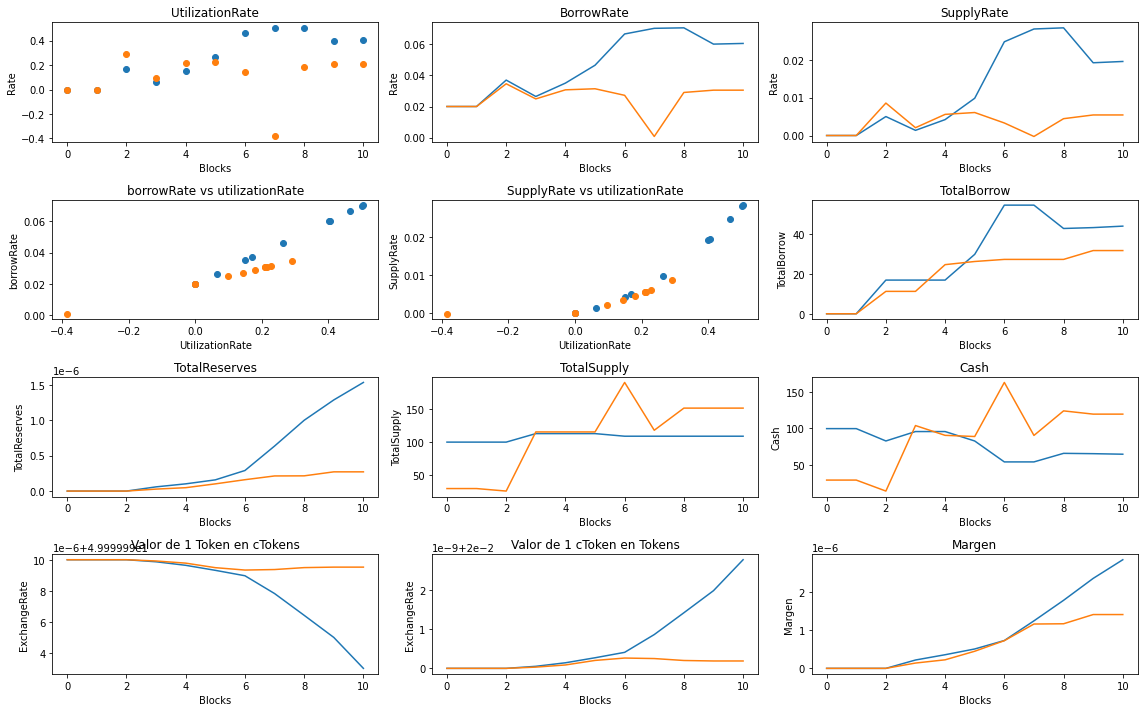

In [ ]:
Er1 = []; Er2 = []  # 1 TK : x cTK
Er11 = []; Er21 = []  # 1 cTK : x TK
Br1 = []; Br2 = []  # BorrowRate  
Ut1 = []; Ut2 = []  # UtilizationRate 
Sr1 = []; Sr2 = []  # SupplyRate
TB1 = []; TB2 = []  # TotalBorrow
Cs1 = []; Cs2 = []  # Cash
TR1 = []; TR2 = []  # TotalReserves
TS1 = []; TS2 = []  # TotalSupply
Mg1 = []; Mg2 = []  # Margen


for block in newMarkets[0]:
    Er1.append(block[4])
    Er11.append(1/block[4])
    Br1.append(block[0])
    Sr1.append(block[1])
    Ut1.append(preutilization_volatileMarket(block[0]))
    TB1.append(block[6])
    Cs1.append(block[8])
    TR1.append(block[3])
    TS1.append(block[7])
    Mg1.append(block[10])
    
for block in newMarkets[1]:
    Er2.append(block[4])
    Er21.append(1/block[4])
    Br2.append(block[0])
    Sr2.append(block[1])
    Ut2.append(preutilization_stableMarket(block[0]))
    TB2.append(block[6])
    Cs2.append(block[8])
    TR2.append(block[3])
    TS2.append(block[7])
    Mg2.append(block[10])

numberBlocks = range(len(newMarkets[1]))

figsize(16,10)

fig, axs = plt.subplots(4, 3)
# UtilizationRate
axs[0, 0].scatter(numberBlocks,Ut1); axs[0, 0].scatter(numberBlocks,Ut2)
axs[0, 0].set(xlabel="Blocks", ylabel="Rate"); axs[0, 0].set_title('UtilizationRate')
# BorrowRate
axs[0, 1].plot(Br1); axs[0, 1].plot(Br2) 
axs[0, 1].set(xlabel="Blocks", ylabel="Rate"); axs[0, 1].set_title('BorrowRate')
# SupplyRate
axs[0, 2].plot(Sr1); axs[0, 2].plot(Sr2) 
axs[0, 2].set(xlabel="Blocks", ylabel="Rate"); axs[0, 2].set_title('SupplyRate')
# borrowRate vs utilizationRate
axs[1, 0].scatter(Ut1,Br1); axs[1, 0].scatter(Ut2,Br2)
axs[1, 0].set(xlabel="UtilizationRate", ylabel="borrowRate"); axs[1, 0].set_title('borrowRate vs utilizationRate')
# SupplyRate vs utilizationRate
axs[1, 1].scatter(Ut1,Sr1); axs[1, 1].scatter(Ut2,Sr2)
axs[1, 1].set(xlabel="UtilizationRate", ylabel="SupplyRate"); axs[1, 1].set_title('SupplyRate vs utilizationRate')
# TotalBorrow
axs[1, 2].plot(TB1); axs[1, 2].plot(TB2)
axs[1, 2].set(xlabel="Blocks", ylabel="TotalBorrow"); axs[1, 2].set_title('TotalBorrow')
# TotalReserves
axs[2, 0].plot(TR1); axs[2, 0].plot(TR2)
axs[2, 0].set(xlabel="Blocks", ylabel="TotalReserves"); axs[2, 0].set_title('TotalReserves')
# TotalSupply
axs[2, 1].plot(TS1); axs[2, 1].plot(TS2)
axs[2, 1].set(xlabel="Blocks", ylabel="TotalSupply"); axs[2, 1].set_title('TotalSupply')
# Cash
axs[2, 2].plot(Cs1); axs[2, 2].plot(Cs2)
axs[2, 2].set(xlabel="Blocks", ylabel="Cash"); axs[2, 2].set_title('Cash')
# ExchangeRate
axs[3, 0].plot(Er1); axs[3, 0].plot(Er2)
axs[3, 0].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 0].set_title('Valor de 1 Token en cTokens')
# bottom = 50-600000000*minAmount; top = 50+6000000000*minAmount
# bottom = 49.9999999999995; top = 50.0000000000005
# axs[3, 0].set(ylim=(bottom,top))

axs[3, 1].plot(Er11); axs[3, 1].plot(Er21)
axs[3, 1].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 1].set_title('Valor de 1 cToken en Tokens')
# bottom = 0.02-100*minAmount; top = 0.02+100*minAmount
# bottom = 0.0199999999999995; top = 0.0200000000000005
# axs[3, 1].set(ylim=(bottom,top))
# Margen
axs[3, 2].plot(Mg1); axs[3, 2].plot(Mg2)
axs[3, 2].set(xlabel="Blocks", ylabel="Margen"); axs[3, 2].set_title('Margen')
fig.tight_layout()

**Cometario 2** Hay que ajustar como se calcula los valores de los agregados a nivel de mercado y despues verificar que la suma de la acumulacion de intereses de los borrowers individuales se ajustan al agregado. Y hacer un seguimiento a los intereses pagados implicitos en el aumento de la tasa de cambio.
* la funcion totalBorrowMarket como refleja los intereses acumulados atraves de indexes[-1]/indexes[-2]?
* estos intereses acumulados se deben llevar a la funcion de las reservas para aplicar el reserve factor y ajustar la reserva en ese monto. Actualmente la funcion totalReserveMarket el reserve factor se esta acplicando sobre el total borrow y deberia ser unicamente sobre el interes acumulado.
* para calcular el cash no se debe considerar la reserva pues no son recursos disponibles solo es lo que queda neto de supply - el neto de borrows.
* Creo que en este modulo se puede introducir una forma de calcular el margen pero esto depende de los intereses acumulados

Sea IA el interes acumulado en cada bloque:
\begin{equation*}
IA= BorrowRate x BlockDelta x Total Borrows
\end{equation*} 
de tal forma que New Borrows $=$ Total Borrows + IA.
Por lo tanto las nuevas reservas se obtienen,
\begin{equation*}
Nuevas Reservas= IA x Reserve Factor (RF) + Total Reserves
\end{equation*} 
De acuerdo al modelo de tasa de interes el interes pagado (IP) a suppliers es
\begin{equation*}
IP= IA * UR
\end{equation*} 
Esto es porque el Supply Rate $=$ BorrowRate x Utilization Rate (UR).

Entonces el Margen en cada momento del protocolo se podira calcular como
\begin{equation*}
Margen= IA-IA*RF-IA*UR
\end{equation*} 

La identidad se interpreta de esta forma en el momento de acumulacion de intereses:
\begin{align*}
Cash + New Borrows - New Reserves &=& New Supply \\
Cash + (Total Borrows + IA) - (Total Reserves+ IA x RF) &=& (Total Supply + IP)
\end{align*} 
El Cash no debe estar afectado por la acumulacion de intereses. Esto quiere decir que los cambios en el Cash son solo por los cambios en Net Borrow y Net Supply.

Para actualizar las demas variables que definen el estado del mercado en el nuevo bloque, debemos contar la cantidad de bloques en las que las tasas de interés no han sufrido cambios, es decir, bloques en los que no hubo cambios entre la oferta y la demanda del mercado. Para esto definiremos la función que cambiará el valor de $t$, el cual como ya mencionamos, será la cantidad de bloques sin cambios en las tasas de interés:

En base al valor de $t$ se calcularán de una u otra forma los intereses tanto del mercado como de los usuarios. Analicemos esto con un ejemplo:

Supongamos que estamos interesados en realizar un suministro al mercado MK1 y que al momento de realizar el suministro las tasas de interes son $\text{Borrow rate}=0.05$ y $\text{Supply rate}=0.02$; nuestros fondos creceran con la misma tasa de interés en tanto que ningún usuario interactue con el mercado MK1, es decir, la tasa de interés será la misma mientras que ningún otro usuario (o nosotros) realicemos un supply, un borrow, un withdraw o un repay.

En este cambio el interés será del tipo **simple**, con lo cual si suponemos que en 100 bloques no se ha realizado niguna acción, tendremos

$$\text{Capital}_{100} = \text{Capital}_0*(1+100*\text{Supply rate})$$

o de manera general,

$$\text{Capital}_{\text{bloque_n}} = \text{Capital}_{\text{bloque_0}}*(1+t*\text{Supply rate})$$

si en $n$ bloques no se ha realizado ninguna acción. Por otro lado, si el valor de $t$ es cero (esto implica que algún usuario realizó una acción en el mercado MK1), se deben capitalizar los intereses, en este punto el interés se transforma en un interés del tipo compuesto, con lo cual si suponemos que en el bloque 101 alguien realizo alguna acción, tendremos

\begin{align}
\text{Capital}_{101}&=\text{Capital}_{100}*(1+\text{New supply rate})\\
&=\text{Capital}_{0}*(1+100*\text{Supply rate})*(1+\text{New supply rate})
\end{align}

Realizando así, el proceso de capitalización de intereses en el momento que se actualizan las tasas del mercado.

![texto del enlace](Imagenes/interest.jpg)

De ese modo, debemos actualziar el saldo total prestado del mercado en base a los intereses (simples o compuesto) que se calculen.

Continuando con la actualización de los valores propios del mercado, tenemos el total de reservas del mercado. Al igual que el saldo total prestado, las reservas tambien se capitalzian de acuerdo a la actualización de las tasas del mercado, con lo cual, la manera en la que se calcularán las reservas en un bloque $n$ será:

$$\text{TotalReserves}_n=\left\{\begin{array}{ll}
\text{TotalReserves}_{0}+\text{TotalBorrow}_{0}*(\text{BorrowRate}*\Delta*\text{ReserveFactor}) & \text{si }\Delta\neq0\\
\text{TotalReserves}_{n-1}+\text{TotalBorrow}_{n-1}*(\text{BorrowRate}*\text{ReserveFactor}) & \text{si }\Delta=0\end{array}\right.$$

La expresión anterior se puede entender como que una parte (tanta como el factor de reserva) de los intereses generados por los prestamos, se irá para la reserva del mercado.

Es momento de establecer el mecanismo por el cual se define la tasa de cambio entre tokens y ctokens. Para comprender esta noción debemos tener presente los siguientes conceptos:

*  **Acuñar tokens (mint tokens):** Es el proceso de suministrar algún activo en el mercado y recibir ctokens a cambio.
*  **Saldo total de subyacente:** Es la cantidad de tokens que hay en el mercado.
*  **Saldo total prestado:** Es la cantidad de tokens prestados.
*  **Reservas:** Reservas actuales del mercado.

Con lo cual, la expresión que define la tasa de cambio en el bloque actual es

$$TokenPrice = \frac{1}{cTokenPrice}=\frac{TotalUnderlyingBalance+TotalBorrowBalance-Reserves}{cTokenMinted}$$

Una característica que cabe mencionar es que a pesar de que la tasa de cambio depende del saldo total suministrado y si este baja, la tasa de cambio tambien podrá bajar, el crecimiento en el valor de los cTokens se verá directamente relacionado con la acumulación de intereses generados por los prestamos de cada usuario.

Para determinar la cantidad $cTokenMinted$ debemos tomar la cantidad de tokens en el mercado (incluyendo los tokens que fueron prestados fuera de intereses) y dividirlos por el precio anterior de los cTokens.

Una vez obtenidos todos los valores anteriormente mencionados, podemos definir el estado del mercado en el siguiente bloque; es importante mencionar que en este punto aun no hemos tomado en cuenta los movimientos de los usuarios.

## Update de los movimientos de los usuarios

Para simular cada una de las acciones que pueden realizar los usuarios será necesario implementar una distribución de probabilidad que modele la cantidad promedio de ocurrencias de algún suceso en un tiempo especifico, en nuestro contexto se traduce por ejemplo, a la cantidad promedio de usuarios que hacen supply en un bloque.

La distribución de probabilidad la podemos entender como una expresión matemática que asigna a cada valor, la probabilidad de que "aparezca" dicho valor. 

En ese sentido, la distribución de probabilidad que mejor se ajusta a nuestra simulación es la distribución de Pöisson, la cual nos indicara la probabilidad de que uno o dos, o 100 usuarios realicen supply (por ejemplo) en un bloque dado.

Para comprender mejor la noción de distribución de probabilidad que vamos a implementar en la simulación realizaremos un ejemplo gráfico.

Supongamos que las condiciones del mercado son tales que el promedio de entradas de suppliers por bloque es 5, la cantidad de borrowers promedio es de 3, la de usuarios que realizan withdraw es de 1 y los que hacen un repay son 2 en promedio. Las distribuciones de probabilidad que se ajustan a estos valores son:


In [ ]:
# Valores estimados de ocerrencias

lambda_suppliers = 5    # Candidad estimada de llegada de suppliers por bloque  
lambda_borrowers = 3    # Candidad estimada de llegada de borrowes por bloque
lambda_withdraws = 1    # Candidad estimada de usuarios que realizan withdraw por bloque
lambda_repays = 2       # Candidad estimada de usuarios que realizan repay por bloque

# Distribuciones de Poisson para los valores dados

suppliersDistribuion = ss.poisson(lambda_suppliers)   
borrowersDistribuion = ss.poisson(lambda_borrowers)   
withdrawsDistribuion = ss.poisson(lambda_withdraws)   
repaysDistribuion = ss.poisson(lambda_repays)

# Visualización

people = np.arange(15)

suppliersProbability = []  
borrowersProbability = []
withdrawsProbability = []
repaysProbability = []

for user in people:
    suppliersProbability.append(suppliersDistribuion.pmf(user))   
    borrowersProbability.append(borrowersDistribuion.pmf(user))   
    withdrawsProbability.append(withdrawsDistribuion.pmf(user))
    repaysProbability.append(repaysDistribuion.pmf(user))

# Visualización
fig = go.Figure()

fig.add_trace(go.Scatter(x=people,y=suppliersProbability,name="Suppliers"))
fig.add_trace(go.Scatter(x=people,y=borrowersProbability,name="Borrowers"))
fig.add_trace(go.Scatter(x=people,y=withdrawsProbability,name="Withdraws"))
fig.add_trace(go.Scatter(x=people,y=repaysProbability,name="Repays"))

fig.update_layout(title="Distribuciones para la acción por parte de cada usuario por bloque",
                  xaxis_title='Cantidad de personas',
                  yaxis_title='Probabilidad')
fig.show()

En la gráfica anterior podemos ver que la probabilidad de que 4 usuarios hagan supply es mayor por ejemplo a la probabilidad de que 4 usuarios hagan withdraw, también podemos ver que es mucho mas probable que 2 usuario hagan repay a que 7 usuarios lo hagan. Esta será la idea que implementaremos para modelar la ocurrencia de cada acción.

In [ ]:
def temporalBlock(market,blockNumber):  # Recibe el bloque anterior
    """
    A temporary copy of the block without market shares is created.
    
    blockNumber : Number of the previous block
    """
    temporal = []
    for value in market[blockNumber][:12]:
        temporal.append(value)
    for user in market[blockNumber][12:]:
        temporal.append(("x",0,user[2],user[3],user[4],user[5]))
    return temporal

def userAtBlock(markets,blockNumber,userIndex):
    """
    Returns the status in each specific block market of a fixed user
    
    blockNumber : Number of the previous block
    userIndex :   Index of the account
    """
    temporalUserAtBlock = []
    for market in markets:
        temporalUserAtBlock.append(market[blockNumber][userIndex])
    return temporalUserAtBlock

def accountLiquidity(markets,blockNumber,collateralFactors,userIndex): 
    """
    Indicates account liquidity and deficit
    
    blockNumber :       Number of the previous block
    collateralFactors : List with all markets collateral factors
    userIndex :         Must be equal to or greater than 11
    """
    tmpUserAtBlock = userAtBlock(markets,blockNumber,userIndex)
    collateralBalance = 0  # Valor en USD
    borrowBalance = 0  # Valor en USD
    for m in range(len(tmpUserAtBlock)):
        index = markets[m][blockNumber][9][-1]/markets[m][blockNumber][9][tmpUserAtBlock[m][5]]
        collateralBalance += (tmpUserAtBlock[m][3]/markets[m][blockNumber][4])*collateralFactors[m]*markets[m][blockNumber][2]
        borrowBalance += (tmpUserAtBlock[m][4]*index)*markets[m][blockNumber][2]
    shortfall = max(borrowBalance - collateralBalance,0)  # Cuanto se deberia liquidar
    liquidity = max(collateralBalance - borrowBalance,0)  # Cuanto le queda de colchon para pedir prestamos
    return (liquidity,shortfall)   #valores en USD
    
# accountLiquidity([M1,M2],0,[0.75,0.75],11)

A continuación definiremos cada uno de los posibles eventos que se pueden presentar en cada bloque:

1.   **Nuevos suppliers**



![texto del enlace](Imagenes/supply.jpg)

In [ ]:
def newSuppliers(market,estimatedOccurrences,blockNumber,maxSupply,restriction=True):  # Recibe el bloque anterior
    """
    Returns potential new suppliers
    
    estimatedOccurrences : The average number of new suppliers per block
    blockNumber          : Receive the previous block
    maxSupply            : Maximum amount of supply
    retriction           : If true no leverage is allowed 
    """
    # Copia temporal del mercado con la copia temporal del bloque anterior
    # -----------------------------------------------------------------------------------------------------
    previousBlockCopy = temporalBlock(market,blockNumber)  # Esta es la que se edita
    # -----------------------------------------------------------------------------------------------------
    # Llegada aleatoria de suppliers
    # -----------------------------------------------------------------------------------------------------
    poissonDistribution = ss.poisson(estimatedOccurrences)  # Se aplica una distribución de Poisson
    n_users = len(previousBlockCopy[12:])
    numberOfPeople = np.arange(n_users)
    probability = [] 
    for i in numberOfPeople:
        probability.append(poissonDistribution.pmf(i))
    numberOfNewSuppliers = random.choices(numberOfPeople,probability)[0]  # Cantidad de nuevos suppliers
    # -----------------------------------------------------------------------------------------------------
    # Se guardan los indices de los usuarios
    # -----------------------------------------------------------------------------------------------------
    users = []
    userIndex = 12
    for user in previousBlockCopy[12:]:
        users.append((user,userIndex))
        userIndex += 1
    # -----------------------------------------------------------------------------------------------------
    # Se registran los nuevos suppliers
    # -----------------------------------------------------------------------------------------------------
    for newSupplier in range(numberOfNewSuppliers):
        user, userIndex = random.sample(users,1)[0]
        users.remove((user, userIndex))
        liquidity,shortfall = accountLiquidity(markets,blockNumber,collateralFactors,userIndex)
        if liquidity > 0:  # La cuenta no esta en zona de liquidación
            indexes = market[blockNumber][9]
            updatedSupply = user[3]/market[blockNumber][4]  # Tokens suplidos con intereses
            updatedBorrow = user[4]*(indexes[-1]/indexes[user[5]])  # Tokens en prestamo con intereses
            if restriction == True:  # Si no se permite el apalancamiento
                if updatedBorrow == 0:   
                    supplied = random.uniform(minAmount,maxSupply)
                    user = ("s",supplied,updatedSupply+supplied,(updatedSupply+supplied)*market[blockNumber][4],
                            updatedBorrow,len(indexes)-1)
                    previousBlockCopy[userIndex] = user
            else:  # Se permite el apalancamiento
                supplied = random.uniform(minAmount,maxSupply)
                user = ("s",supplied,updatedSupply+supplied,(updatedSupply+supplied)*market[blockNumber][4],
                        updatedBorrow,len(indexes)-1)
                previousBlockCopy[userIndex] = user
        else:
            previousBlockCopy[userIndex] = user
    # -----------------------------------------------------------------------------------------------------
    return previousBlockCopy

2.  **Nuevos borrowers**

![texto del enlace](Imagenes/borrow.jpg)

Para determinar la capacidad de prestamo de cada usuario, se deben tener en cuenta los movimientos del mismo usuario en todos los mercados, el siguiente diagrama nos permite determinar el valor de la capacidad de prestamo:

![texto del enlace](Imagenes/borrow_limit.jpg)

Las casillas que vemos en el paso intermedio del diagrama anterior, corresponde con los balances del usuario en cada mercado, al realizar el dichos calculos se suman los valores obtenidos y el resultado será la capacidad de préstamo del usuario.

In [ ]:
# marketBor --> Mercado donde se va a pedir prestado
def newBorrowers(markets,marketBor,estimatedOccurrences,blockNumber,collateralFactors):  # Recibe el bloque anterior
    """
    Returns potential new borrowers
    
    markets              : List with all markets
    marketBor            : Market where new borrowers are to be generated
    estimatedOccurrences : The average number of new borrowers per block
    blockNumber          : Receive the previous block
    collateralFactors    : List with all markets collateral factors
    """
    # Copia temporal del mercado con la copia temporal del bloque anterior
    # -----------------------------------------------------------------------------------------------------
    previousBlockCopy = temporalBlock(marketBor,blockNumber)  # Esta es la que se edita
    # -----------------------------------------------------------------------------------------------------
    # Llegada aleatoria de borrowers
    # -----------------------------------------------------------------------------------------------------
    poissonDistribution = ss.poisson(estimatedOccurrences)  # Distribución de Possion
    n_users = len(previousBlockCopy[12:])
    numberOfPeople = np.arange(n_users)
    probability = []
    for i in numberOfPeople:
        probability.append(poissonDistribution.pmf(i))
    numberOfNewBorrowers = random.choices(numberOfPeople,probability)[0]
    # -----------------------------------------------------------------------------------------------------
    # Se guardan los indices de los usuarios
    # -----------------------------------------------------------------------------------------------------
    users = []
    userIndex = 12
    for user in previousBlockCopy[12:]:
        users.append((user,userIndex))
        userIndex += 1
    # -----------------------------------------------------------------------------------------------------
    # Se registran los nuevos borrowers
    # -----------------------------------------------------------------------------------------------------
    for newBorrower in range(numberOfNewBorrowers):
        user, userIndex = random.sample(users,1)[0]
        users.remove((user, userIndex))
        liquidity,shortfall = accountLiquidity(markets,blockNumber,collateralFactors,userIndex)
        if liquidity > 0:  # Si la cuenta no esta en zona de liquidación
            indexes = marketBor[blockNumber][9]
            updatedSupply = user[3]/marketBor[blockNumber][4]
            updatedBorrow = user[4]*(indexes[-1]/indexes[user[5]])
            marketLiquidity = marketBor[blockNumber][8]  # Cash del mercado  
            liquidityInTokens = liquidity/marketBor[blockNumber][2]
            limit = min(liquidityInTokens,marketLiquidity)  # Se revisa si hay suficiente cash en el mercado
            if limit > minAmount:
                borrowed = random.uniform(minAmount,limit)
                user = ("b",borrowed,updatedSupply,user[3],updatedBorrow+borrowed,len(indexes)-1)  
                previousBlockCopy[userIndex]=user                                           
        else:
            previousBlockCopy[userIndex]=user 
    # -----------------------------------------------------------------------------------------------------
    return previousBlockCopy

3.   **Nuevos withdraws**

![texto del enlace](Imagenes/withdraw.jpg)

En el diagráma anterior aparecen dos nuevos conceptos que no habiamos mencionado, el **ratio** del usuario y la **liquidez del mercado**.

Recordemos que el collateral factor nos indicaba el porcentaje de colateral que podiamos tomar prestado, el ratio es el reciproco del collateral factor, es decir, el ratio nos permite determinar cual es la cantidad de collateral que necesitamos para dar garantia sobre el prestamo que tenemos.

Por ejemplo, supongamos que tenemos un deposito de 100 tokens en el mercado $MK1$, el cual cuenta con un collateral factor de $75\%$, esto nos indica que podemos realizar un prestamo de hasta 75 tokens en el mercado. Supongamos que realizamos dicho prestamo y que posteriormente pagamos 50 tokens de la deuda, quedandonos asi un saldo de 25 tokens en el prestamo (para el ejemplo no tomaremos en cuenta los intereses), la pregunta sería que tanto podemos sacar del colateral que teniamos? La respuesta nos la da el ratio y se calcula de la siguiente manera

\begin{align}
ratio &= \frac{1}{collateralFactor}*borrowBalance \\
&=\frac{1}{75\%}*25\\
&=33.3
\end{align}

De ese modo podremos realizar un withdraw de hasta $66.6\text{ tokens} = 100-33.3$.

Por otro lado tenemos la liquidez del mercado, la cual en terminos concretos es la cantidad de tokens que hay en el mercado, incluyendo las reservas. Cabe resaltar que si se retiran tokens de la reserva se esta adquiriendo riesgo de liquidez en el mercado. 

La manera en la que se calcula la liquidez del mercado es 

$$\text{liquidity}=\text{total supply}-\text{total borrow balance}$$



In [ ]:
# Nuevos Withdraws
def newWithdraws(markets,marketWith,estimatedOccurrences,blockNumber,collateralFactors): # Recibe el bloque anterior
    """
    Returns potential new withdraws
    
    markets              : List with all markets
    marketWith           : Market where new withdraws are to be generated
    estimatedOccurrences : The average number of new borrowers per block
    blockNumber          : Receive the previous block
    collateralFactors    : List with all markets collateral factors
    """
    # Copia temporal del mercado con la copia temporal del bloque anterior
    # -----------------------------------------------------------------------------------------------------
    previousBlockCopy = temporalBlock(marketWith,blockNumber)  # Esta es la que se edita
    # -----------------------------------------------------------------------------------------------------
    # Se guardan los indices de los usuarios
    # -----------------------------------------------------------------------------------------------------
    suppliers = []
    users = []
    userIndex = 12
    for user in previousBlockCopy[12:]:
        if user[3] > 0:
            suppliers.append((user,userIndex))
        users.append((user,userIndex))
        userIndex += 1
    numberOfPeople = np.arange(len(suppliers))
    # -----------------------------------------------------------------------------------------------------
    # Llegada aleatoria de withdraws
    # -----------------------------------------------------------------------------------------------------
    poissonDistribution = ss.poisson(estimatedOccurrences)  # Distribución de Possion
    probability = []
    for i in numberOfPeople:
        probability.append(poissonDistribution.pmf(i))
    if len(numberOfPeople) == 0:
        return previousBlockCopy
    numberOfNewWithdraws = random.choices(numberOfPeople,probability)[0]
    # -----------------------------------------------------------------------------------------------------
    # Se registran los nuevos withdraws
    # -----------------------------------------------------------------------------------------------------
    numberOfNewWithdraws = min(numberOfNewWithdraws, len(suppliers))
    for newWith in range(numberOfNewWithdraws):
        user, userIndex = random.sample(users,1)[0]
        users.remove((user, userIndex))
        liquidity,shortfall = accountLiquidity(markets,blockNumber,collateralFactors,userIndex)
        if liquidity > 0:
            indexes = marketWith[blockNumber][9]
            updatedSupply = user[3]/marketWith[blockNumber][4]
            updatedBorrow = user[4]*(indexes[-1]/indexes[user[5]])
            liquidityInTokens = liquidity/marketWith[blockNumber][2]
            marketLiquidity = marketWith[blockNumber][8] + marketWith[blockNumber][3] # Cash + Reservas del mercado
            limit = min(updatedSupply,liquidityInTokens,marketLiquidity)
            if limit > minAmount:
                withdrawn = random.uniform(minAmount,limit)
                user = ("w",withdrawn,updatedSupply-withdrawn,(updatedSupply-withdrawn)*marketWith[blockNumber][4],
                        updatedBorrow, len(indexes)-1)
                previousBlockCopy[userIndex]=user
        else:
            previousBlockCopy[userIndex]=user
    return previousBlockCopy

# printMarket(M1)
# newWith = newWithdraws([M1,M2],M1,2,0,[0.2,0.2])
# printMarket([newWith])

4.  **Nuevos repays**

![texto del enlace](Imagenes/repay.jpg)

In [ ]:
# Nuevos Repays
def newRepays(market, estimatedOccurrences, blockNumber):  # Recibe el bloque anterior
    """
    Returns potential new repays
    
    estimatedOccurrences : The average number of new borrowers per block
    blockNumber          : Receive the previous block
    """
    # Copia temporal del mercado con la copia temporal del bloque anterior
    # -----------------------------------------------------------------------------------------------------
    previousBlockCopy = temporalBlock(market,blockNumber)  # Esta es la que se edita
    # -----------------------------------------------------------------------------------------------------
    # Se guardan los indices de los usuarios
    # -----------------------------------------------------------------------------------------------------
    borrowers = []
    users = []
    userIndex = 12
    for user in previousBlockCopy[12:]:
        if user[4] > 0:
            borrowers.append((user,userIndex))
        users.append((user,userIndex))
        userIndex += 1
    numberOfPeople = np.arange(len(borrowers))
    if len(numberOfPeople) == 0:
        return previousBlockCopy
    # -----------------------------------------------------------------------------------------------------
    # Llegada aleatoria de withdraws
    # -----------------------------------------------------------------------------------------------------
    poissonDistribution = ss.poisson(estimatedOccurrences)  # Distribución de Possion
    probability = []
    for i in numberOfPeople:
        probability.append(poissonDistribution.pmf(i))
    numberOfNewRepays = random.choices(numberOfPeople,probability)[0]
    numberOfNewRepays = min(numberOfNewRepays,len(borrowers))
    # -----------------------------------------------------------------------------------------------------
    # Se registran los nuevos withdraws
    # -----------------------------------------------------------------------------------------------------
    for newRepay in range(numberOfNewRepays):
        user, userIndex = random.sample(users,1)[0]
        users.remove((user, userIndex))
        liquidity,shortfall = accountLiquidity(markets,blockNumber,collateralFactors,userIndex)
        if liquidity > 0:
            indexes = market[blockNumber][9]
            updatedSupply = user[3]/market[blockNumber][4]
            updatedBorrow = user[4]*(indexes[-1]/indexes[user[5]])
            if updatedBorrow > 0:
                repay = random.uniform(minAmount,updatedBorrow) 
                user = ("r",repay, updatedSupply, user[3], updatedBorrow-repay, len(indexes)-1)
            previousBlockCopy[userIndex]=user
        else:
            previousBlockCopy[userIndex]=user
    return previousBlockCopy

In [ ]:
suppliersPerBlock = 1 # suppliersPerBlock
borrowersPerBlock = 5 # borrowersPerBlock
withdrawsPerBlock = 1 # withdrwasPerBlock
repaysPerBlock = 1 # repaysPerBlock

def newBlockMarket(markets,marketIndex,collateralFactors,blockNumber,reserveFactor,priceMarket,interestModel,maxSupply,restriction=True):
    """
    Creates a new block for the market by adding users' shares
    
    marketIndex       : Position in which the market we are going to trade is located in the market list
    collateralFactors : List with all markets collateral factors
    blockNumber       : Receive the new block      
    priceMarket       : The new price market
    interestModel     : Interest model considered for the market
    maxSupply         : Maximum amount of supply
    restriction       : If true no leverage is allowed
    """    
    # Copia temporal del mercado con la copia temporal del bloque anterior
    # -----------------------------------------------------------------------------------------------------
    previousBlockCopy = temporalBlock(markets[marketIndex],blockNumber-1)  # Esta es la que se edita
    previousBlockMarkets = []
    for market in markets:
        marketCopy = []
        for value in market[blockNumber-1]:
            marketCopy.append(value)
        previousBlockMarkets.append([marketCopy])
    # -----------------------------------------------------------------------------------------------------
    # Se actualizan y se guardan las variables del mercado en el nuevo bloque en base al bloque anterior
    # -----------------------------------------------------------------------------------------------------
    newBlockMarket = setMarketVariablesInBlock(markets[marketIndex],blockNumber,reserveFactor,priceMarket,interestModel)
    markets[marketIndex].append(newBlockMarket)  # Se guarda el nuevo bloque en el mercado
    # -----------------------------------------------------------------------------------------------------
    # Se reportan las nuevas acciones
    # -----------------------------------------------------------------------------------------------------
    userIndex = 12
    for user in previousBlockCopy[12:]:
        # -----------------------------------------------------------------------------------------------------
        # Se generan las posibles nuevas acciones de los usuarios
        # -----------------------------------------------------------------------------------------------------
        newSup = newSuppliers([previousBlockCopy],suppliersPerBlock,0,maxSupply,restriction)  
        newBor = newBorrowers(previousBlockMarkets,[previousBlockCopy],borrowersPerBlock,0,collateralFactors)
        newWith = newWithdraws(previousBlockMarkets,[previousBlockCopy],withdrawsPerBlock,0,collateralFactors)
        newRep = newRepays([previousBlockCopy],repaysPerBlock,0)  
        # Se escoge una aleatoria
        actions = [newSup[userIndex],newBor[userIndex],newWith[userIndex],newRep[userIndex]]
        action = random.sample(actions,1)[0]
        previousBlockCopy[userIndex] = action
        if action[0] == "w" and action[1] >= markets[marketIndex][blockNumber][8]:
            previousBlockCopy[3] = previousBlockCopy[3] - (action[1] + previousBlockCopy[8])
            previousBlockCopy[8] = 0
        if action[0] == "w" and action[1] < markets[marketIndex][blockNumber][8]:
            previousBlockCopy[3] = previousBlockCopy[3] - (action[1] + previousBlockCopy[8])
            previousBlockCopy[8] -= action[1]
        elif action[0] == "s":
            previousBlockCopy[7] += action[1]
            previousBlockCopy[8] += action[1]
        elif action[0] == "b":
            previousBlockCopy[6] += action[1]
            previousBlockCopy[8] -= action[1]
        elif action[0] == "r":
            previousBlockCopy[6] -= action[1]
            previousBlockCopy[8] += action[1]
        userIndex += 1
    markets[marketIndex][blockNumber][11:] = previousBlockCopy[11:]
    # -----------------------------------------------------------------------------------------------------
    return markets[marketIndex]

# random.seed(123455)

M1 = marketSetUp(5,0.2,0.5,10,50,getBorrowAPR_volatileMarket)
M2 = marketSetUp(5,0.15,0.8,5,20,getBorrowAPR_volatileMarket)
markets = [M1,M2]

# # print("======================================================= M1 ======================================================")
# printMarket(M1)
# # print("\n======================================================= M2 =======================================================")
# printMarket(M2)

M1 = newBlockMarket(markets,0,[0.75,0.75],1,0.2,11,getBorrowAPR_volatileMarket,50)
M2 = newBlockMarket(markets,1,[0.75,0.75],1,0.2,5,getBorrowAPR_volatileMarket,20)
markets = [M1,M2]

M1 = newBlockMarket(markets,0,[0.75,0.75],2,0.2,11,getBorrowAPR_volatileMarket,50)
M2 = newBlockMarket(markets,1,[0.75,0.75],2,0.2,5,getBorrowAPR_volatileMarket,20)

# # print("======================================================= M1 ======================================================")
printMarket(M1)
# # print("\n======================================================= M2 =======================================================")
printMarket(M2)



accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 10
totalSupplies: 12.2633911704772 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 12.2633911704772
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  s          |  11.61331   |  11.61331   |  580.66559  |  0.00000    |  0          |
|  0          |  3          |  s          |  0.65008    |  0.65008    |  32.50

## Generación del nuevo bloque

In [ ]:
liquidationIncentive = 0.08
closeFactor = 0.5

def totalBorrowUser(markets,blockNumber,userConfigurations,userIndex): # Recibe el nuevo bloque
    """
    Returns the user's total debt in USD
    
    markets :            List with all markets
    blockNumber :        Receive the new block
    userConfigurations : List with configurations of the user at each market
    userIndex :          Must be equal to or greater than 11
    """
    borrow = 0
    AtMarkets = userAtBlock(markets,blockNumber,userIndex)
    for m in range(len(markets)):
        index = markets[m][blockNumber][9][-1]/markets[m][blockNumber][9][userConfigurations[m][5]]
        borrow += userConfigurations[m][4]*index*markets[m][blockNumber][2]
    return borrow  # En USD

userConfigurations = userAtBlock([M1,M2],0,12)
totalBorrowUser([M1,M2],0,userConfigurations,12)

0.0

In [ ]:
def payLoanPerMarket(pay,market,userConfigurationAtMarket,blockNumber,userIndex):
    """
    Returns a list of the remaining balance to the liquidator and the update of the borrower's debt in the market.
    
    pay :                Amount paid in debt by the liquidator in USD
    market :             Market where the liquidator pays the debt
    blockNumber :        Receive the new block
    userConfigurations : List with configurations of the user at each market
    userIndex :          Must be equal to or greater than 11
    """
    index = market[blockNumber][9][-1]/market[blockNumber][9][userConfigurationAtMarket[5]]
    updatedBorrow = userConfigurationAtMarket[4]*index
    amount = pay/market[blockNumber][2]   # Valor del pago en tokens del mercado
    balance = updatedBorrow - amount
    updatedSupply = userConfigurationAtMarket[3]/market[blockNumber][4]
    if balance >= 0:
        user = ("x",0,updatedSupply,userConfigurationAtMarket[3],balance,len(market[blockNumber][9])-1)
        pay = 0  # El liquidador se gasto toda la plata
    else:
        user = ("x",0,updatedSupply,userConfigurationAtMarket[3],0,len(market[blockNumber][9])-1)
        pay = abs(balance)*market[blockNumber][2]   # Valor actualizado del pago en USD
    userConfigurationAtMarket = user
    return [pay, userConfigurationAtMarket]

In [ ]:
def payPerLiquidation(payPerLiq,market,blockNumber,userIndex):
    """
    Returns a list of what remains to be paid to the liquidator and the update of the borrower's collateral in the market.
    
    payPerLiq :          Amount to be paid to the liquidator
    market :             Market in which the liquidator receives the collateral
    blockNumber :        Receive the new block
    userConfigurations : List with configurations of the user at each market
    userIndex :          Must be equal to or greater than 11
    """
    userConfigurationAtMarket = tuple(market[blockNumber][userIndex])
    index = market[blockNumber][9][-1]/market[blockNumber][9][userConfigurationAtMarket[5]]
    updatedBorrow = userConfigurationAtMarket[4]*index
    amount = payPerLiq/market[blockNumber][2]   # Valor del pago en tokens del mercado
    updatedSupply = userConfigurationAtMarket[3]/market[blockNumber][4]
    balance = updatedSupply - amount
    if balance >= 0:
        user = ("x",0,balance,balance*market[blockNumber][4],updatedBorrow,len(market[blockNumber][9])-1)
        payPerLiq = 0  # Se le pago todo al liquidador
    else:
        user = ("x",0,0,0,updatedBorrow,len(market[blockNumber][9])-1)
        payPerLiq = abs(balance)*market[blockNumber][2]   # Valor actualizado del pago en USD
    userConfigurationAtMarket = user
    return [payPerLiq, userConfigurationAtMarket]

In [ ]:
def newLiquidator(markets,blockNumber,userConfigurationAtMarkets,pay,userIndex,liquidationIncentive=liquidationIncentive):
    """
    Returns user settings in each market after settlement
    
    markets :              List with all markets
    blockNumber :          Receive the new block
    userConfigurations :   List with configurations of the user at each market
    pay :                  Amount paid in debt by the liquidator in USD
    userIndex :            Must be equal to or greater than 11
    liquidationIncentive : Liquidation incentive defined for liquidators
    """
    # ------------------------------------------------------------------------------------------------------------------
    # Valores en USD
    # ------------------------------------------------------------------------------------------------------------------
    totalPay = pay  # Valor que paga el liquidador en USD
    payPerLiq = totalPay*(1 + liquidationIncentive)  # Valor que debe recibir el liquidador en USD
    # ------------------------------------------------------------------------------------------------------------------
    # Mercados de mas volatil a mas estable
    # ------------------------------------------------------------------------------------------------------------------
    for m in range(len(userConfigurationAtMarkets)):
        updatedPayPerLiq = payPerLiquidation(payPerLiq,markets[m],blockNumber,userIndex)
        payPerLiq = updatedPayPerLiq[0]  # Monto que queda por pagar al liquidador en USD
        userConfigurationAtMarkets[m] = updatedPayPerLiq[1]  # Configuraciones luego de realizar los pagos al liquidador
        if payPerLiq == 0:   # Si ya no se le debe mas al liquidador, rompa el ciclo
            break
    # ------------------------------------------------------------------------------------------------------------------
    # Mercados de mas estable a mas volatil
    # ------------------------------------------------------------------------------------------------------------------
    userConfigurationAtMarkets = userConfigurationAtMarkets[::-1]
    markets = markets[::-1]
    for m in range(len(userConfigurationAtMarkets)):
        updatedPayLoan = payLoanPerMarket(pay,markets[m],userConfigurationAtMarkets[m],blockNumber,userIndex)
        pay = updatedPayLoan[0]  # Monto que le queda al liquidador por pagar
        userConfigurationAtMarkets[m] = updatedPayLoan[1]  # Configuraciones luego de realizar los pagos del liquidador
        if pay == 0:  # Si el liquidador se gasto toda la plata, rompa el ciclo
            break
    # ------------------------------------------------------------------------------------------------------------------
    # Se reordenan los mercados de mas volatil a mas estable
    # ------------------------------------------------------------------------------------------------------------------
    userConfigurationAtMarkets = userConfigurationAtMarkets[::-1]
    markets = markets[::-1]
    return userConfigurationAtMarkets

In [ ]:
def liquidation(markets,blockNumber,userIndex,collateralFactors,liquidationIncentive=liquidationIncentive,closeFactor=closeFactor,txFee=0,traddingFee=0):
    """
    Performs the necessary settlements to bring the account out of insolvency
    
    markets :              List with all markets
    blockNumber :          Receive the new block
    userIndex :            Must be equal to or greater than 11
    collateralFactors :    List with all markets collateral factors
    liquidationIncentive : Liquidation incentive defined for liquidators
    closeFactor :          Maximum percentage that the liquidators can liquidate of the borrower's debt
    """
    marketsCopy = []
    for market in markets:
        marketsCopy.append([market[blockNumber]])
    userConfigurationAtMarkets = userAtBlock(marketsCopy,0,userIndex)
    liquidity, shortfall = accountLiquidity(marketsCopy,0,collateralFactors,userIndex)
    totalPay = 0
    n_liquidators = 0
    liquidatorsLog = []
    if shortfall > 0:
        borrow = totalBorrowUser(marketsCopy,0,userConfigurationAtMarkets,userIndex)  # Deuda total de la cuenta
        totalBorrow = borrow
        pay = totalBorrow*closeFactor  # ¡¡¡Este valor debe cambiarse de manera aleatoria para la siguiente versión!!!
        profit = pay*(1+liquidationIncentive) - pay - txFee - traddingFee  # Ganancias del liquidador en USD
        while shortfall > 0 and borrow != 0 and profit > 0:
            totalPay += pay  # Se va guardando la información de los pagos
            configurationsAfterLiquidation = newLiquidator(marketsCopy,0,userConfigurationAtMarkets,pay,userIndex,
                                                           liquidationIncentive)
            for m in range(len(userConfigurationAtMarkets)): # Se guardan los efectos de la liquidación
                userConfigurationAtMarkets[m] = configurationsAfterLiquidation[m]
                marketsCopy[m][0][userIndex] = configurationsAfterLiquidation[m]
            # Se recalculan los valores a ver si entran mas liquidadores
            shortfall -= pay
            borrow -= pay
            profit = pay*(1+liquidationIncentive) - pay - txFee - traddingFee
            n_liquidators += 1
        liquidatorsLog.append([blockNumber,userIndex,n_liquidators,totalPay])
        for m in range(len(userConfigurationAtMarkets)):
            userConfigurationAtMarket = ("l",totalPay,userConfigurationAtMarkets[m][2],userConfigurationAtMarkets[m][3],
                                         userConfigurationAtMarkets[m][4],userConfigurationAtMarkets[m][5])
            userConfigurationAtMarkets[m] = userConfigurationAtMarket  
            # Se guarda la información de la liquidación en las configuraciones del mercado
        return (userConfigurationAtMarkets,liquidatorsLog)
    else:
        return (userConfigurationAtMarkets,[])

In [ ]:
random.seed(123455)

M1 = marketSetUp(5,0.2,0.5,10,50,getBorrowAPR_volatileMarket)
M2 = marketSetUp(5,0.15,0.8,5,20,getBorrowAPR_volatileMarket)
markets = [M1,M2]

printMarket(M1)
printMarket(M2)

In [ ]:
def newBlockWithLiquidations(markets,blockNumber,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies):
    """
    Generates new blocks for each market, taking into account the settlements.
    
    markets :              List with all markets
    blockNumber :          Receive the new block
    collateralFactors :    List with all markets collateral factors
    reserveFactors :       List with all markets reserve factors
    priceMarkets :         List with all new markets price
    interestModels :       List of all models of interest considered for each market
    maxSupplies :          List with all the maximum amounts allowed for supply
    """
    for m in range(len(markets)):
        markets[m] = newBlockMarket(markets,m,collateralFactors,blockNumber,reserveFactors[m],priceMarkets[m],
                                    interestModels[m],maxSupplies[m])
    userIndex = 12
    configurationsOfAllUsers = []
    for user in range(len(markets[0][blockNumber][12:])):
        configurations, liquidatorsLog = liquidation(markets,blockNumber,userIndex,collateralFactors)
        configurationsOfAllUsers.append((userIndex,configurations))
        userIndex += 1
    for configuration in configurationsOfAllUsers:
        userIndex, userConfigurations = configuration
        for m in range(len(userConfigurations)):
            markets[m][blockNumber][userIndex] = userConfigurations[m]
    return markets

random.seed(123455)

M1 = marketSetUp(5,0.2,0.5,10,50,getBorrowAPR_volatileMarket)
M2 = marketSetUp(5,0.15,0.8,1.01,20,getBorrowAPR_stableMartet)
markets = [M1,M2]

collateralFactors = [0.75,0.75]
priceMarkets = [10,1.01]
interestModels = [getBorrowAPR_volatileMarket,getBorrowAPR_stableMartet]
maxSupplies = [50,20]

newMarkets = newBlockWithLiquidations(markets,1,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies)
newMarkets = newBlockWithLiquidations(newMarkets,2,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies)
# newBlock

In [ ]:
printMarket(newMarkets[0])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 10
totalSupplies: 47.476518293143535 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 47.476518293143535
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  3          |  s          |  43.43976   |  43.43976   |  2

In [ ]:
printMarket(newMarkets[1])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 1.01
totalSupplies: 58.45526879022458 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 58.45526879022458
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  s          |  16.44999   |  16.44999   |  822.49934  |  0.00000    |  0          |
|  0          |  2          |  s          |  11.94273   |  11.94273   |  597.13660  |  0.00000    |  0          |
|  0          |  3          |  s          |  17.65527   |  17.65527   |  8

In [ ]:
random.seed(123455)

M1 = marketSetUp(5,0.2,0.5,10,50,getBorrowAPR_volatileMarket)
M2 = marketSetUp(5,0.15,0.8,1.01,20,getBorrowAPR_stableMartet)
markets = [M1,M2]

collateralFactors = [0.75,0.75]
priceMarkets = [10,1.01]
interestModels = [getBorrowAPR_volatileMarket,getBorrowAPR_stableMartet]
maxSupplies = [50,20]
newMarkets = markets

for i in range(1,101):
    # newMarkets = newBlockWithLiquidations(newMarkets,i,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies)
    newMarkets[0] = newBlockMarket(newMarkets,0,collateralFactors,i,0.2,5,getBorrowAPR_volatileMarket,100)
    newMarkets[1] = newBlockMarket(newMarkets,1,collateralFactors,i,0.15,10,getBorrowAPR_stableMartet,100)
    newMarkets = [newMarkets[0], newMarkets[1]]
# newBlock

In [ ]:
printMarket(newMarkets[0])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 10
totalSupplies: 47.476518293143535 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 47.476518293143535
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  2          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  3          |  s          |  43.43976   |  43.43976   |  2

In [ ]:
printMarket(newMarkets[1])

accrualBlockNumber: 0 	 exchangeRate: 50 	 marketPrice: 1.01
totalSupplies: 58.45526879022458 	 totalBorrows: 0 	 totalReserves: 0
borrowRateAPR: 0.02 	 supplyRateAPR: 0.0 	 MarketCash: 58.45526879022458
MarketIndex: 9.5129e-09 	 Margen: 0 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  s          |  16.44999   |  16.44999   |  822.49934  |  0.00000    |  0          |
|  0          |  2          |  s          |  11.94273   |  11.94273   |  597.13660  |  0.00000    |  0          |
|  0          |  3          |  s          |  17.65527   |  17.65527   |  8

In [ ]:
Er1 = []; Er2 = []  # 1 TK : x cTK
Er11 = []; Er21 = []  # 1 cTK : x TK
Br1 = []; Br2 = []  # BorrowRate  
Ut1 = []; Ut2 = []  # UtilizationRate 
Sr1 = []; Sr2 = []  # SupplyRate
TB1 = []; TB2 = []  # TotalBorrow
Cs1 = []; Cs2 = []  # Cash
TR1 = []; TR2 = []  # TotalReserves
TS1 = []; TS2 = []  # TotalSupply
Mg1 = []; Mg2 = []  # Margen


for block in newMarkets[0]:
    Er1.append(block[4])
    Er11.append(1/block[4])
    Br1.append(block[0])
    Sr1.append(block[1])
    Ut1.append(preutilization_volatileMarket(block[0]))
    TB1.append(block[6])
    Cs1.append(block[8])
    TR1.append(block[3])
    TS1.append(block[7])
    Mg1.append(block[10])
    
for block in newMarkets[1]:
    Er2.append(block[4])
    Er21.append(1/block[4])
    Br2.append(block[0])
    Sr2.append(block[1])
    Ut2.append(preutilization_stableMarket(block[0]))
    TB2.append(block[6])
    Cs2.append(block[8])
    TR2.append(block[3])
    TS2.append(block[7])
    Mg2.append(block[10])

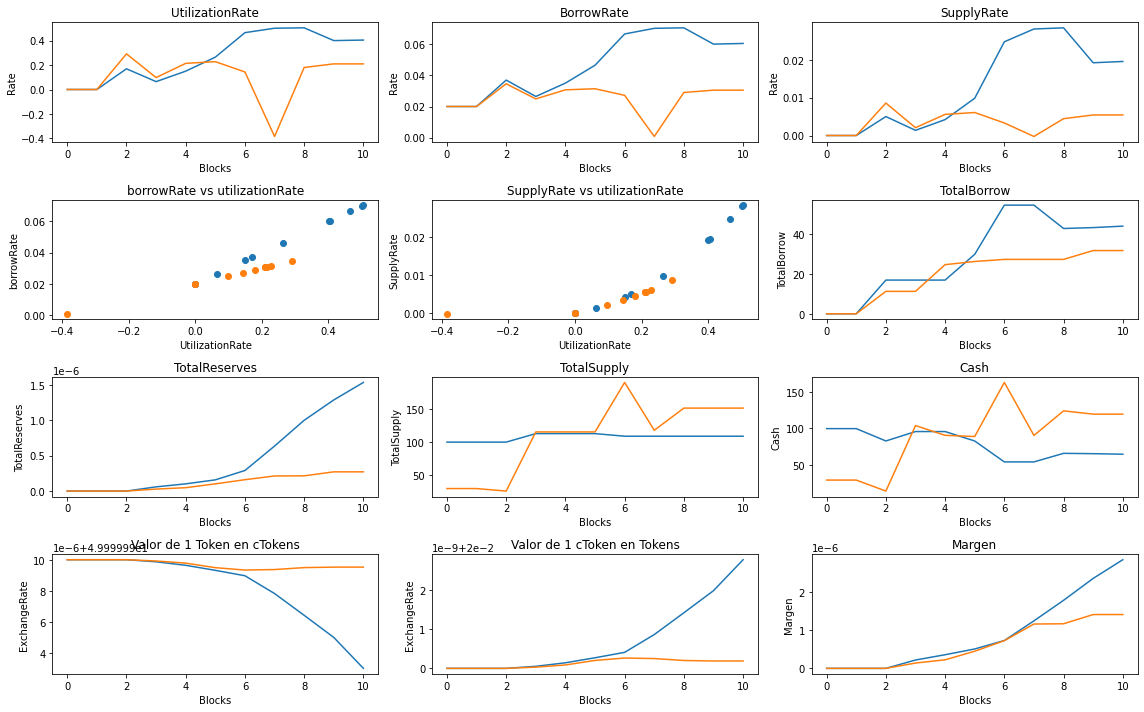

In [ ]:
Er1 = []; Er2 = []  # 1 TK : x cTK
Er11 = []; Er21 = []  # 1 cTK : x TK
Br1 = []; Br2 = []  # BorrowRate  
Ut1 = []; Ut2 = []  # UtilizationRate 
Sr1 = []; Sr2 = []  # SupplyRate
TB1 = []; TB2 = []  # TotalBorrow
Cs1 = []; Cs2 = []  # Cash
TR1 = []; TR2 = []  # TotalReserves
TS1 = []; TS2 = []  # TotalSupply
Mg1 = []; Mg2 = []  # Margen


for block in newMarkets[0][:20]:
    Er1.append(block[4])
    Er11.append(1/block[4])
    Br1.append(block[0])
    Sr1.append(block[1])
    Ut1.append(preutilization_volatileMarket(block[0]))
    TB1.append(block[6])
    Cs1.append(block[8])
    TR1.append(block[3])
    TS1.append(block[7])
    Mg1.append(block[10])
    
for block in newMarkets[1][:20]:
    Er2.append(block[4])
    Er21.append(1/block[4])
    Br2.append(block[0])
    Sr2.append(block[1])
    Ut2.append(preutilization_stableMarket(block[0]))
    TB2.append(block[6])
    Cs2.append(block[8])
    TR2.append(block[3])
    TS2.append(block[7])
    Mg2.append(block[10])

figsize(16,10)

fig, axs = plt.subplots(4, 3)
# UtilizationRate
axs[0, 0].plot(Ut1); axs[0, 0].plot(Ut2)
axs[0, 0].set(xlabel="Blocks", ylabel="Rate"); axs[0, 0].set_title('UtilizationRate')
# BorrowRate
axs[0, 1].plot(Br1); axs[0, 1].plot(Br2) 
axs[0, 1].set(xlabel="Blocks", ylabel="Rate"); axs[0, 1].set_title('BorrowRate')
# SupplyRate
axs[0, 2].plot(Sr1); axs[0, 2].plot(Sr2) 
axs[0, 2].set(xlabel="Blocks", ylabel="Rate"); axs[0, 2].set_title('SupplyRate')
# borrowRate vs utilizationRate
axs[1, 0].scatter(Ut1,Br1); axs[1, 0].scatter(Ut2,Br2)
axs[1, 0].set(xlabel="UtilizationRate", ylabel="borrowRate"); axs[1, 0].set_title('borrowRate vs utilizationRate')
# SupplyRate vs utilizationRate
axs[1, 1].scatter(Ut1,Sr1); axs[1, 1].scatter(Ut2,Sr2)
axs[1, 1].set(xlabel="UtilizationRate", ylabel="SupplyRate"); axs[1, 1].set_title('SupplyRate vs utilizationRate')
# TotalBorrow
axs[1, 2].plot(TB1); axs[1, 2].plot(TB2)
axs[1, 2].set(xlabel="Blocks", ylabel="TotalBorrow"); axs[1, 2].set_title('TotalBorrow')
# TotalReserves
axs[2, 0].plot(TR1); axs[2, 0].plot(TR2)
axs[2, 0].set(xlabel="Blocks", ylabel="TotalReserves"); axs[2, 0].set_title('TotalReserves')
# TotalSupply
axs[2, 1].plot(TS1); axs[2, 1].plot(TS2)
axs[2, 1].set(xlabel="Blocks", ylabel="TotalSupply"); axs[2, 1].set_title('TotalSupply')
# Cash
axs[2, 2].plot(Cs1); axs[2, 2].plot(Cs2)
axs[2, 2].set(xlabel="Blocks", ylabel="Cash"); axs[2, 2].set_title('Cash')
# ExchangeRate
axs[3, 0].plot(Er1); axs[3, 0].plot(Er2)
axs[3, 0].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 0].set_title('Valor de 1 Token en cTokens')
# bottom = 50-600000000*minAmount; top = 50+6000000000*minAmount
# bottom = 49.9999999999995; top = 50.0000000000005
# axs[3, 0].set(ylim=(bottom,top))

axs[3, 1].plot(Er11); axs[3, 1].plot(Er21)
axs[3, 1].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 1].set_title('Valor de 1 cToken en Tokens')
# bottom = 0.02-100*minAmount; top = 0.02+100*minAmount
# bottom = 0.0199999999999995; top = 0.0200000000000005
# axs[3, 1].set(ylim=(bottom,top))
# Margen
axs[3, 2].plot(Mg1); axs[3, 2].plot(Mg2)
axs[3, 2].set(xlabel="Blocks", ylabel="Margen"); axs[3, 2].set_title('Margen')
fig.tight_layout()

In [ ]:
printMarket(M1[60:80])

accrualBlockNumber: 0 	 exchangeRate: 2.169778401575 	 marketPrice: 10
totalSupplies: 5.9486954407822 	 totalBorrows: 33.7216373311001 	 totalReserves: 1.52945766e-05
borrowRateAPR: 0.0583481652274 	 supplyRateAPR: 0.0179003606468 	 MarketCash: 3.6674798842725
MarketIndex: 9.51292340791579e-09 	 Margen: 4.3535035e-06 

| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  # Block    |  UserIdx    |  Action     |  Amount     |  Supply     |  SPlusI     |  Borrow     |  IUIdx      |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|  0          |  0          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.00000    |  0          |
|  0          |  1          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.12613    |  39         |
|  0          |  2          |  x          |  0.00000    |  0.00000    |  0.00000    |  0.01424    |  37      

In [ ]:
printMarket(M1[90:])

In [ ]:
TRU_supply = [6000,1000,5000,6000,1000,8000,1000,1500,2000,2000]
TRU_borrow = [2000,1500,8000,1000,500,5000,300,500,1000,2000]
TRU_withdraw = [1000,500,2000,450,1500,200,250,1000,2000,200]
TRU_repays = [150,900,500,800,200,500,250,1000,1000,1000]
suppliersPerDay = sum(TRU_supply)/len(TRU_supply)
suppliersPerBlock = suppliersPerDay/(4*60*24)
borrowersPerDay = sum(TRU_borrow)/len(TRU_borrow)
borrowersPerBlock = borrowersPerDay/(4*60*24)
withdrwasPerDay = sum(TRU_withdraw)/len(TRU_withdraw)
withdrwasPerBlock = withdrwasPerDay/(4*60*24)
repaysPerDay = sum(TRU_repays)/len(TRU_repays)
repaysPerBlock = repaysPerDay/(4*60*24)
#people = int(suppliersPerBlock+borrowersPerBlock+withdrwasPerBlock+repaysPerBlock)

print(suppliersPerBlock, borrowersPerBlock,withdrwasPerBlock,repaysPerBlock)
#print(suppliersPerBlock/people,borrowersPerBlock/people,withdrwasPerBlock/people,repaysPerBlock/people)

In [ ]:
History = pd.read_excel("Historico para la simulación.xlsx")
BTC_base = History["BTC base"]
BTC_crash = History["BTC crash"]
DAI_base = History["DAI base"]
DAI_vol = History["DAI vol"]
ETH_base = History["ETH base"]
ETH_crash = History["ETH crash"]
RIF_base = History["RIF base"]

History.head()

In [ ]:
figsize(16,12)

fig, axs = plt.subplots(4, 3)

plt.subplot(4,2,1)
plt.title("BTC base")
plt.ylim((20000,60000))
BTC_base.plot()

plt.subplot(4,2,2)
plt.title("BTC crash")
plt.ylim((20000,60000))
BTC_crash.plot()

plt.subplot(4,2,3)
plt.title("ETH base")
plt.ylim((600,2000))
ETH_base.plot()

plt.subplot(4,2,4)
plt.title("ETH crash")
plt.ylim((600,2000))
ETH_crash.plot()

plt.subplot(4,2,5)
plt.title("DAI base")
plt.ylim((0.99,1.009))
DAI_base.plot()

plt.subplot(4,2,6)
plt.title("DAI volatil")
plt.ylim((0.99,1.009))
DAI_vol.plot()

plt.subplot(4,2,7)
plt.title("RIF base")
plt.ylim((0.25,0.38))
RIF_base.plot()

plt.subplot(4,2,8)
plt.title("RIF base")
plt.ylim((0.25,0.38))
RIF_base.plot()

fig.tight_layout()

In [ ]:
# Primer escenario
# BTC, RIF

BTC_prices = list(BTC_crash)
RIF_prices = list(RIF_base)

BTC = marketSetUp(5,0.2,0.5,BTC_prices[0],0.5,getBorrowAPR_volatileMarket)
RIF = marketSetUp(5,0.15,0.8,RIF_prices[0],800,getBorrowAPR_stableMartet)
markets = [BTC,RIF]

printMarket(BTC)
printMarket(RIF)

In [ ]:
collateralFactors = [0.5,0.75]
interestModels = [getBorrowAPR_volatileMarket,getBorrowAPR_stableMartet]
maxSupplies = [1.2,1000]
newMarkets = markets

for i in range(1,1001):
    priceMarkets = [BTC_prices[i],RIF_prices[i]]
    newMarkets = newBlockWithLiquidations(newMarkets,i,collateralFactors,reserveFactors,priceMarkets,interestModels,maxSupplies)

In [ ]:
ErBTC = []; ErRIF = []  # 1 TK : x cTK
ErcBTC = []; ErcRIF = []  # 1 cTK : x TK
BrBTC = []; BrRIF = []  # BorrowRate  
UtBTC = []; UtRIF = []  # UtilizationRate 
SrBTC = []; SrRIF = []  # SupplyRate
TBBTC = []; TBRIF = []  # TotalBorrow
CsBTC = []; CsRIF = []  # Cash
TRBTC = []; TRRIF = []  # TotalReserves
TSBTC = []; TSRIF = []  # TotalSupply

for block in newMarkets[0]:
    ErBTC.append(block[4])
    ErcBTC.append(1/block[4])
    BrBTC.append(block[0])
    SrBTC.append(block[1])
    UtBTC.append(preutilization_volatileMarket(block[0]))
    TBBTC.append(block[6]*block[2])
    CsBTC.append(block[8]*block[2])
    TRBTC.append(block[3]*block[2])
    TSBTC.append(block[7]*block[2])
    
for block in newMarkets[1]:
    ErRIF.append(block[4])
    ErcRIF.append(1/block[4])
    BrRIF.append(block[0])
    SrRIF.append(block[1])
    UtRIF.append(preutilization_stableMarket(block[0]))
    TBRIF.append(block[6]*block[2])
    CsRIF.append(block[8]*block[2])
    TRRIF.append(block[3]*block[2])
    TSRIF.append(block[7]*block[2])
    
fig, axs = plt.subplots(4, 3)
# UtilizationRate
axs[0, 0].plot(UtBTC); axs[0, 0].plot(UtRIF)
axs[0, 0].set(xlabel="Blocks", ylabel="Rate"); axs[0, 0].set_title('UtilizationRate')
# BorrowRate
axs[0, 1].plot(BrBTC); axs[0, 1].plot(BrRIF) 
axs[0, 1].set(xlabel="Blocks", ylabel="Rate"); axs[0, 1].set_title('BorrowRate')
# SupplyRate
axs[0, 2].plot(SrBTC); axs[0, 2].plot(SrRIF) 
axs[0, 2].set(xlabel="Blocks", ylabel="Rate"); axs[0, 2].set_title('SupplyRate')
# borrowRate vs utilizationRate
axs[1, 0].scatter(UtBTC,BrBTC); axs[1, 0].scatter(UtRIF,BrRIF)
axs[1, 0].set(xlabel="UtilizationRate", ylabel="borrowRate"); axs[1, 0].set_title('borrowRate vs utilizationRate')
# SupplyRate vs utilizationRate
axs[1, 1].scatter(UtBTC,SrBTC); axs[1, 1].scatter(UtRIF,SrRIF)
axs[1, 1].set(xlabel="UtilizationRate", ylabel="SupplyRate"); axs[1, 1].set_title('SupplyRate vs utilizationRate')
# TotalBorrow
axs[1, 2].plot(TBBTC); axs[1, 2].plot(TBRIF)
axs[1, 2].set(xlabel="Blocks", ylabel="TotalBorrow"); axs[1, 2].set_title('TotalBorrow')
# TotalReserves
axs[2, 0].plot(TRBTC); axs[2, 0].plot(TRRIF)
axs[2, 0].set(xlabel="Blocks", ylabel="TotalReserves"); axs[2, 0].set_title('TotalReserves')
# TotalSupply
axs[2, 1].plot(TSBTC); axs[2, 1].plot(TSRIF)
axs[2, 1].set(xlabel="Blocks", ylabel="TotalSupply"); axs[2, 1].set_title('TotalSupply')
# Cash
axs[2, 2].plot(CsBTC); axs[2, 2].plot(CsRIF)
axs[2, 2].set(xlabel="Blocks", ylabel="Cash"); axs[2, 2].set_title('Cash')
# ExchangeRate
axs[3, 0].plot(ErBTC); axs[3, 0].plot(ErRIF)
axs[3, 0].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 0].set_title('Valor de 1 Token en cTokens')
# bottom = 49.9999999999997; top = 50.0000000000003
bottom = 49.999997; top = 50.000003
# bottom = 49.995; top = 50.005
axs[3, 0].set(ylim=(bottom,top))
axs[3, 1].plot(ErcBTC); axs[3, 1].plot(ErcRIF)
axs[3, 1].set(xlabel="Blocks", ylabel="ExchangeRate"); axs[3, 1].set_title('Valor de 1 cToken en Tokens')
# bottom = 0.0199999999999997; top = 0.0200000000000003
bottom = 0.019999997; top = 0.020000003
# bottom = 0.019995; top = 0.020003
axs[3, 1].set(ylim=(bottom,top))
fig.tight_layout()